## Линейная регрессия

Скачайте данные в формате `csv`. В качестве целевой переменной возьмём число случаев заболевания (столбцы `total_cases` и `new_cases`).

Кривая общего числа заболевших во время эпидемии в реальности имеет сигмоидальный вид: после начальной фазы экспоненциального роста происходит насыщение.
В качестве конкретной формы такой сигмоиды будем использовать форму функции распределения для гауссиана:

$$\Phi = \frac{1}{\sqrt{2 \pi}} \int_{-\infty}^{x} e^{-{t^2}/{2}} dt.$$

Гауссиан выбран потому, что с ним будет легче всего работать.

В нашем случае сигмоида стремится не к единице, т.е. константа перед интегралом может быть произвольной (и её можно внести в экспоненту),
а в экспоненте под интегралом может быть произвольная квадратичная функция от t.

- Предложите способ обучать параметры такой сигмоидальной функции при помощи линейной регрессии. Для однообразия будем обучать модель на данных первых 60 дней эпидемии (начиная с 3 марта 2020 года) и делать прогнозы на 30 дней вперёд.

- Обучите эти параметры на данных случаев коронавируса в России. Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).

- Посемплируйте много разных кривых количества новых/общих случаев из апостериорного распределения, постройте графики. Постройте эмпирическое предсказательное распределение, нарисуйте графики. Что можно сказать о прогнозах такой модели?

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

rus_df = pd.read_csv('russia_mar2020_sep2020.csv')

t_all = np.arange(len(rus_df))
y_new_all = rus_df['new_cases'].values
y_tot_all = rus_df['total_cases'].values

N_train = 60
N_forecast = 30
N_total = N_train + N_forecast

t_train = t_all[:N_train]
y_new_train = y_new_all[:N_train]

### Параметризация сигмоиды через квадратичную функцию

Возьмём  произвольную квадратичную функцию от t

$$
q(t) = \beta_2 t^2 + \beta_1 t + \beta_0
$$

Тогда модель для числа новых случаев в день t имеет вид

$$
\text{new}(t) \propto \exp\big(q(t)\big)
= \exp\big(\beta_2 t^2 + \beta_1 t + \beta_0\big)
$$

Переходя к логарифму наблюдаемых новых случаев

$$
z_t = \log\big(\text{new_cases}(t) + \varepsilon\big),
$$

получаем линейную по параметрам модель

$$
z_t \approx \beta_0 + \beta_1 t + \beta_2 t^2 + \varepsilon_t,
$$

Таким образом, для обучения параметров мы используем линейную регрессию с признаками

$$
x_0(t) = 1,\quad x_1(t) = t,\quad x_2(t) = t^2
$$

In [28]:
eps = 1.0
z_train = np.log(y_new_train + eps)

# матрица признаков X: [1, t, t^2]
X = np.vstack([np.ones_like(t_train), t_train, t_train**2]).T
N, p = X.shape  # N=60, p=3

$$
{\boldsymbol{\beta}}_{\mathrm{MAP}}
=
\arg\min_{\boldsymbol{\beta}}
\;\|\mathbf{z} - \mathbf{X}\boldsymbol{\beta}\|^2
=
(\mathbf{X}^\top \mathbf{X})^{-1}\mathbf{X}^\top \mathbf{z}
$$

In [29]:
# MAP-оценка параметров
# находим параметры beta, которые лучше всего аппроксимируют z ≈ X beta
beta_map = np.linalg.lstsq(X, z_train, rcond=None)[0]
print(f"beta_MAP = {beta_map}")

beta_MAP = [ 0.04255188  0.26048743 -0.00181027]


$$
{\sigma}^2
=
\frac{1}{N - p}
\mathbf{r}^\top \mathbf{r}
=
\frac{1}{N - p}
\sum_{t=1}^{N}
\big(z_t - \mathbf{x}_t^\top \hat{\boldsymbol{\beta}}_{\mathrm{MAP}}\big)^2
$$

In [30]:
# Оцениваем дисперсию шума σ²
resid = z_train - X @ beta_map
sigma2 = (resid @ resid) / (N - p)
print(f"σ² = {sigma2}")

σ² = 0.164398827355739


$$
\boldsymbol{\beta}
\sim
\mathcal{N}\!\left(
\mathbf{0},\ \alpha^{-1}\mathbf{I}
\right),
\qquad
\alpha \ll 1
$$
$$
\mathbf{S}
=
\left(
\alpha \mathbf{I}
+
\frac{1}{\hat{\sigma}^2}
\mathbf{X}^\top \mathbf{X}
\right)^{-1}
$$
$$
\mathbf{m}
=
\mathbf{S}
\frac{1}{\hat{\sigma}^2}
\mathbf{X}^\top \mathbf{z}
$$
$$
\boldsymbol{\beta} \mid \mathbf{z}
\sim
\mathcal{N}\!\left(
\mathbf{m},\ \mathbf{S}
\right)
$$

In [31]:
alpha = 1e-6 # "широкий" prior
I = np.eye(p)

S = np.linalg.inv(alpha * I + (X.T @ X) / sigma2)   # ковариация апостериора параметров
m = S @ (X.T @ z_train) / sigma2                    # апостериорное среднее параметров
print("Апостериорное распределение параметров:")
print(f"beta_0 ~ N({m[0]:.4f}, {np.sqrt(S[0,0]):.4f}^2)")
print(f"beta_1 ~ N({m[1]:.4f}, {np.sqrt(S[1,1]):.4f}^2)")
print(f"beta_2 ~ N({m[2]:.4e}, {np.sqrt(S[2,2]):.4e}^2)")

Апостериорное распределение параметров:
beta_0 ~ N(0.0426, 0.1519^2)
beta_1 ~ N(0.2605, 0.0119^2)
beta_2 ~ N(-1.8103e-03, 1.9521e-04^2)


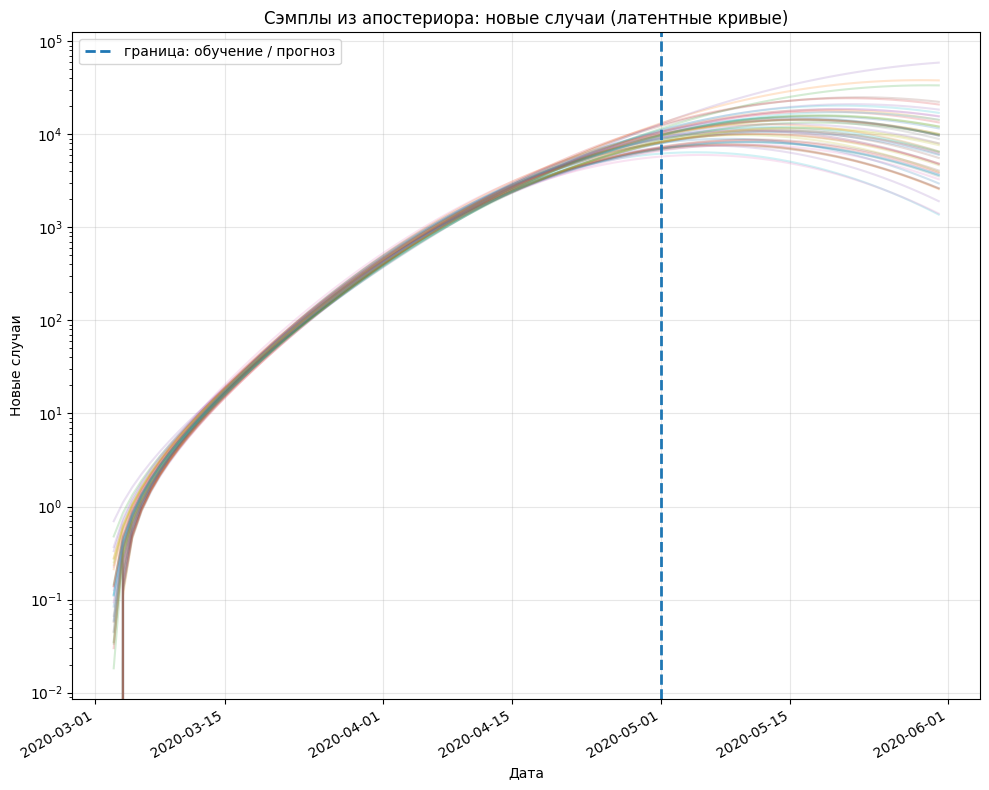

In [66]:
# Семплируем параметры из апостериора
S_samp = 2000
betas = np.random.multivariate_normal(mean=m, cov=S, size=S_samp)

# Строим много кривых new_cases(t)
t_all = np.arange(N_train + N_forecast)
X_all = np.column_stack([np.ones_like(t_all), t_all, t_all**2])

# Создаем латентные кривые new_cases
Z = betas @ X_all.T
new = np.maximum(0.0, np.exp(Z) - eps)

# Рисуем
plt.figure(figsize=(10, 8))

x_dates = pd.to_datetime(rus_df["date"]).iloc[:N_train + N_forecast]
plt.xticks(rotation=30, ha="right")

for i in range(50):
    plt.plot(x_dates, new[i], alpha=0.2)

plt.axvline(x_dates.iloc[N_train - 1], linestyle="--", linewidth=2, label="граница: обучение / прогноз")

plt.title("Сэмплы из апостериора: новые случаи (латентные кривые)")
plt.xlabel("Дата")
plt.ylabel("Новые случаи")
plt.yscale("log")

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

$$
z^{\ast}(t) = z(t) + \varepsilon_t,
\qquad
\varepsilon_t \sim \mathcal{N}(0,\sigma^2)
$$

In [67]:
# Добавляем шум наблюдений
Z_pred = Z + np.random.normal(loc=0.0, scale=np.sqrt(sigma2), size=Z.shape)
new_pred = np.maximum(0.0, np.exp(Z_pred) - eps)

# сумма new_cases
total0 = y_tot_all[0]
total_pred = total0 + np.cumsum(new_pred, axis=1)

# квантили предсказательного распределения (медиана и 95% интервал)
q_new = np.quantile(new_pred, [0.05, 0.5, 0.95], axis=0)
q_tot = np.quantile(total_pred, [0.05, 0.5, 0.95], axis=0)

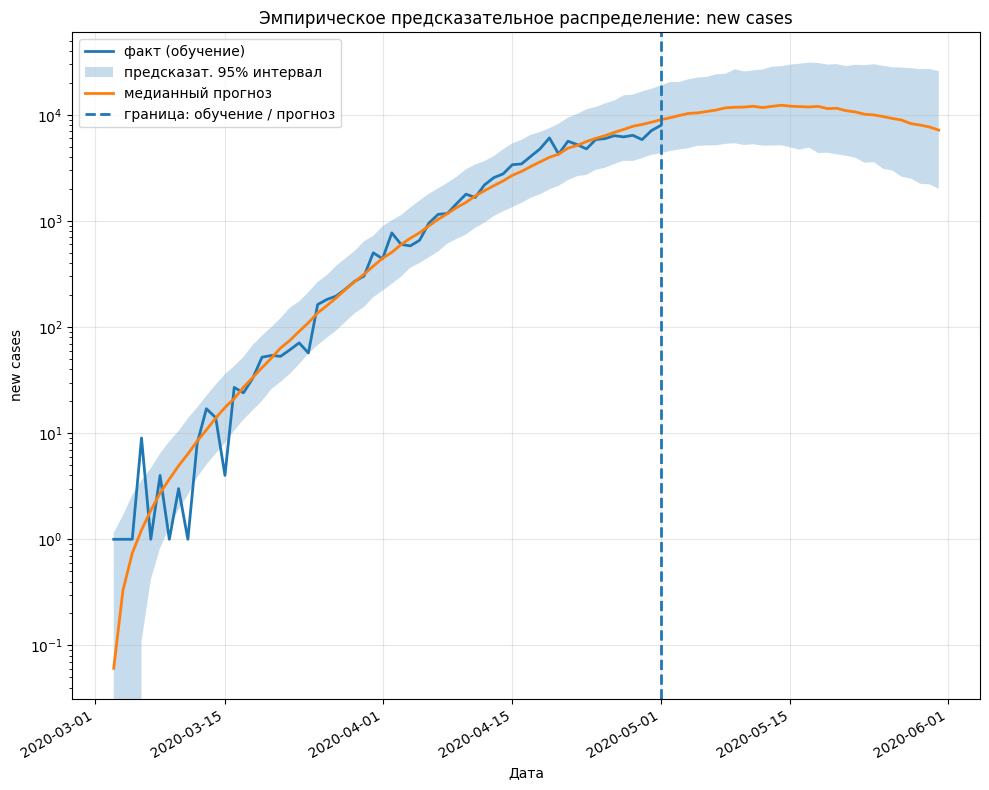

In [68]:
# Рисуем
plt.figure(figsize=(10, 8))
plt.xticks(rotation=30, ha="right")

# фактические new_cases на обучении
plt.plot(x_dates.iloc[:N_train], y_new_train, linewidth=2, label="факт (обучение)")

# предсказательная полоса и медиана
plt.fill_between(x_dates, q_new[0], q_new[2], alpha=0.25, label="предсказат. 95% интервал")
plt.plot(x_dates, q_new[1], linewidth=2, label="медианный прогноз")

plt.axvline(x_dates.iloc[N_train - 1], linestyle="--", linewidth=2, label="граница: обучение / прогноз")
plt.title("Эмпирическое предсказательное распределение: new cases")
plt.xlabel("Дата")
plt.ylabel("new cases")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

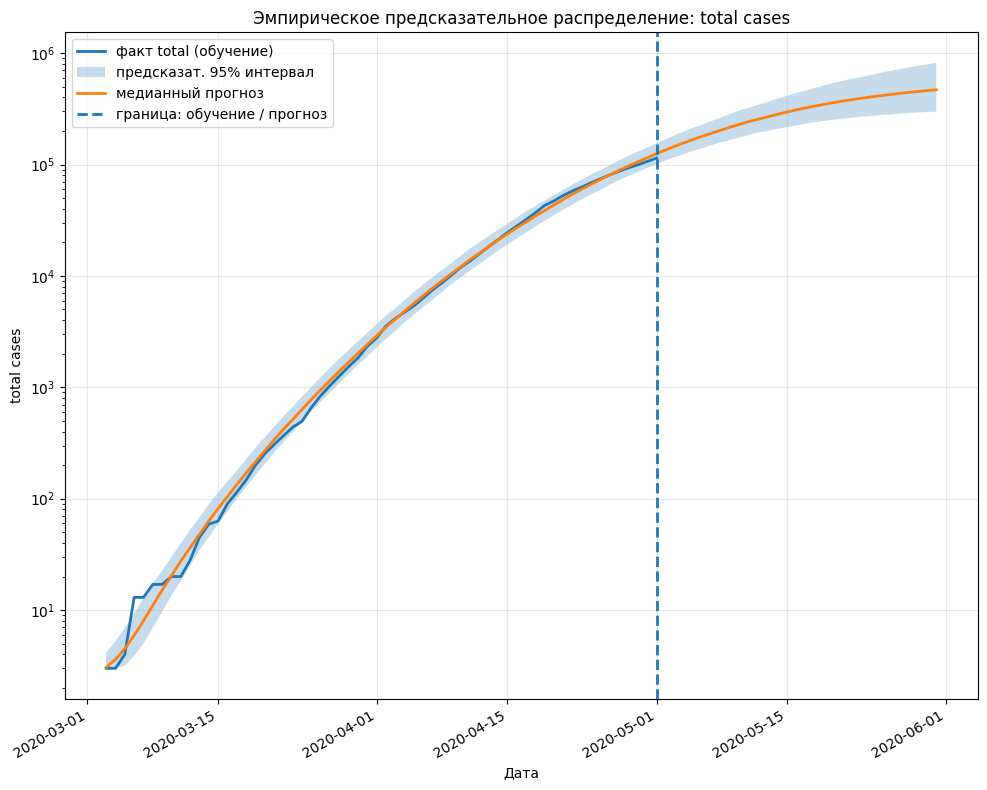

In [69]:
# Рисуем
plt.figure(figsize=(10, 8))
plt.xticks(rotation=30, ha="right")

# фактические total_cases на обучении
plt.plot(x_dates.iloc[:N_train], y_tot_all[:N_train], linewidth=2, label="факт total (обучение)")

# предсказательная полоса и медиана
plt.fill_between(x_dates, q_tot[0], q_tot[2], alpha=0.25, label="предсказат. 95% интервал")
plt.plot(x_dates, q_tot[1], linewidth=2, label="медианный прогноз")

plt.axvline(x_dates.iloc[N_train - 1], linestyle="--", linewidth=2, label="граница: обучение / прогноз")
plt.title("Эмпирическое предсказательное распределение: total cases")
plt.xlabel("Дата")
plt.ylabel("total cases")
plt.yscale("log")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()